In [ ]:
!pip install accelerate
!pip install transformers[torch]
!pip install accelerate -U
!pip install torch==2.1.0
!pip install torchaudio==2.1.0 torchdata==0.7.0 torchtext==0.16.0 torchvision==0.16.0
!pip uninstall transformers torch accelerate
!pip install transformers[torch] accelerate

In [ ]:
# !pip install tensorflow
!pip install ftfy==5.1
# !pip install spacy
!python -m spacy download en
!pip install tensorboardX
# !pip install tqdm
# !pip install pandas
!pip install ipython

Data Mining Final Project

Walleed Khan

Negin Baghbanzadeh **bold text**

# COMET setup
This part gets the common sense from COMET and save it to COMET_out.csv file. You can skip running this part since it will take hours to run and just run the second part (BERT) where it uses the COMET_out.csv file

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/atcbosselut/comet-commonsense.git

In [ ]:
!bash /content/comet-commonsense/scripts/setup/get_atomic_data.sh
!bash /content/comet-commonsense/scripts/setup/get_conceptnet_data.sh
!bash /content/comet-commonsense/scripts/setup/get_model_files.sh

In [ ]:
# !cd drive/MyDrive/EECS_6412_Data_Mining/comet-commonsense/
%cd /content/drive/MyDrive/comet-commonsense
%ls

/content/drive/.shortcut-targets-by-id/1-0PKRTnyEuZkgUdW4mXOTii_qJkSZDIj/comet-commonsense
config/  LICENSE  parameters_names.json  pretrained_models.tar  scripts/  utils/
data/    model/   pretrained_models/     README.md              src/


In [ ]:
import time

In [ ]:
import os
import sys
import torch

sys.path.append(os.getcwd())

import src.data.data as data
import src.data.config as cfg
import src.interactive.functions as interactive

device = "cpu"
model_file = "pretrained_models/atomic_pretrained_model.pickle"
sampling_algorithm = "greedy"

opt, state_dict = interactive.load_model_file(model_file)

data_loader, text_encoder = interactive.load_data("atomic", opt)

n_ctx = data_loader.max_event + data_loader.max_effect
n_vocab = len(text_encoder.encoder) + n_ctx
model = interactive.make_model(opt, n_vocab, n_ctx, state_dict)
sampler = interactive.set_sampler(opt, sampling_algorithm, data_loader)

if device != "cpu":
    cfg.device = int(device)
    cfg.do_gpu = True
    torch.cuda.set_device(cfg.device)
    model.cuda(cfg.device)
else:
    cfg.device = "cpu"

Loading data from: data/atomic/processed/generation/categories_oEffect#oReact#oWant#xAttr#xEffect#xIntent#xNeed#xReact#xWant-maxe1_17-maxe2_35-maxr_1.pickle
52


In [ ]:
import re

In [ ]:
def contains_long_word(sentence, length_threshold=18):
    """
    Checks if the sentence contains any word longer than the specified length threshold.

    Args:
    sentence (str): The sentence to be checked.
    length_threshold (int): The length threshold for the words.

    Returns:
    bool: True if there is a word longer than the threshold, False otherwise.
    """
    words = sentence.split()
    for word in words:
        if len(word) > length_threshold:
            return True
    return False

In [ ]:
def get_common_sense(input_events, category):
  out = []
  for input_event in input_events:
    words = input_event.split()
    cleaned_words = [word for word in words if not re.search(r'\W', word)]
    input_event = ' '.join(cleaned_words)
    input_event = re.sub(r'\d+', '', input_event)

    outputs = interactive.get_atomic_sequence(
      input_event, model, sampler, data_loader, text_encoder, category)

    out.append(outputs[category]["beams"][0])
    # time.sleep(0.5)
  return out

In [ ]:
def split_sentence(sentence, max_length=50):
    """
    Splits a sentence into parts, each of which is not longer than max_length.

    Args:
    sentence (str): The sentence to be split.
    max_length (int): Maximum length of each part.

    Returns:
    list: A list of parts of the sentence.
    """
    words = sentence.split()
    parts = []
    current_part = ""

    for word in words:
        # Check if adding the next word exceeds the max length
        if len(current_part) + len(word) + 1 <= max_length:
            current_part += (word + " ")
        else:
            # Append the current part and start a new one
            parts.append(current_part.strip())
            current_part = word + " "

    # Add the last part if it's not empty
    if current_part:
        parts.append(current_part.strip())

    return parts

In [ ]:
import pandas as pd

df = pd.read_csv("/content/amazon_reviews.csv")
df.dropna(subset=['reviewText'], inplace=True)

In [ ]:
df = df.loc[:, ~df.columns.str.contains('Unnamed')]

In [ ]:
df

,overall,reviewText
0,4,No issues.
1,5,"Purchased this for my device, it worked as adv..."
2,4,it works as expected. I should have sprung for...
3,5,This think has worked out great.Had a diff. br...
4,5,"Bought it with Retail Packaging, arrived legit..."
...,...,...
4910,1,I bought this Sandisk 16GB Class 10 to use wit...
4911,5,Used this for extending the capabilities of my...
4912,5,Great card that is very fast and reliable. It ...
4913,5,Good amount of space for the stuff I want to d...


In [ ]:
df["xReact"] = [get_common_sense(split_sentence(value), "xReact") for value in df["reviewText"]]


Streaming output truncated to the last 5000 lines.
Input Event:   times are no problems so came
Target Effect: xReact

Candidate Sequences:
happy


Input Event:   with case and good
Target Effect: xReact

Candidate Sequences:
good


Input Event:   Card is recognized as as
Target Effect: xReact

Candidate Sequences:
proud


Input Event:   able to carry around all of my music without
Target Effect: xReact

Candidate Sequences:
happy


Input Event:   having to carry an iPod as It came
Target Effect: xReact

Candidate Sequences:
happy


Input Event:   with a plastic case with an SD card
Target Effect: xReact

Candidate Sequences:
guilty


Input Event:   I love the is only a place you can
Target Effect: xReact

Candidate Sequences:
happy


Input Event:   review the product not the The
Target Effect: xReact

Candidate Sequences:
satisfied


Input Event:   handling sucked the product is
Target Effect: xReact

Candidate Sequences:
satisfied


Input Event:   I ordered this to replace an aging C

In [ ]:
df

,overall,reviewText,xReact
0,4,No issues.,[happy]
1,5,"Purchased this for my device, it worked as adv...","[happy, happy, happy, proud]"
2,4,it works as expected. I should have sprung for...,"[happy, happy, happy, dirty]"
3,5,This think has worked out great.Had a diff. br...,"[happy, happy, satisfied, informed, sad, happy..."
4,5,"Bought it with Retail Packaging, arrived legit...","[satisfied, happy, happy, satisfied, happy, ha..."
...,...,...,...
4910,1,I bought this Sandisk 16GB Class 10 to use wit...,"[happy, happy, bad, happy, happy, happy, sad]"
4911,5,Used this for extending the capabilities of my...,"[happy, happy, ready, and and]"
4912,5,Great card that is very fast and reliable. It ...,"[happy, happy, happy, excited, happy]"
4913,5,Good amount of space for the stuff I want to d...,"[happy, happy]"


In [ ]:
file_path = '/content/drive/My Drive/COMET_out.csv'

# Save the DataFrame to CSV
df.to_csv(file_path, index=False)

In [ ]:
df["xIntent"] = [get_common_sense(split_sentence(value), "xIntent") for value in df["reviewText"]]

Streaming output truncated to the last 5000 lines.
Input Event:   times are no problems so came
Target Effect: xIntent

Candidate Sequences:
none


Input Event:   with case and good
Target Effect: xIntent

Candidate Sequences:
to win


Input Event:   Card is recognized as as
Target Effect: xIntent

Candidate Sequences:
none


Input Event:   able to carry around all of my music without
Target Effect: xIntent

Candidate Sequences:
to be helpful


Input Event:   having to carry an iPod as It came
Target Effect: xIntent

Candidate Sequences:
to listen to music


Input Event:   with a plastic case with an SD card
Target Effect: xIntent

Candidate Sequences:
to be a fraud


Input Event:   I love the is only a place you can
Target Effect: xIntent

Candidate Sequences:
none


Input Event:   review the product not the The
Target Effect: xIntent

Candidate Sequences:
to be successful


Input Event:   handling sucked the product is
Target Effect: xIntent

Candidate Sequences:
none


Input Event: 

In [ ]:
file_path = '/content/drive/My Drive/COMET_out.csv'

# Save the DataFrame to CSV
df.to_csv(file_path, index=False)

# BERT

In [ ]:
import pandas as pd

df = pd.read_csv("/content/COMET_out.csv")

In [ ]:
# Convert string representation of list to actual list and remove duplicates
df['xIntent'] = df['xIntent'].apply(lambda x: list(set(eval(x))))
df['xReact'] = df['xReact'].apply(lambda x: list(set(eval(x))))

# Create new column
df['Summary3'] = df.apply(lambda row: f"CustomerX intended {' and '.join(row['xIntent'])} "
                                        f"commented {row['reviewText']}", axis=1)

df['Summary2'] = df.apply(lambda row: f"CustomerX "
                                        f"reacted {' and '.join(row['xReact'])} "
                                        f"commented {row['reviewText']}", axis=1)

df['Summary'] = df.apply(lambda row: f"CustomerX intended {' and '.join(row['xIntent'])} "
                                        f"reacted {' and '.join(row['xReact'])} "
                                        f"commented {row['reviewText']}", axis=1)

In [ ]:
df.head()

,overall,reviewText,xReact,xIntent,Summary,Labels
0,4,No issues.,[happy],[to be a good citizen],Customer intended to be a good citizen reacted...,positive
1,5,"Purchased this for my device, it worked as adv...","[happy, proud]","[to be entertained, none, to be helpful]",Customer intended to be entertained and none a...,positive
2,4,it works as expected. I should have sprung for...,"[happy, dirty]",[none],Customer intended none reacted happy and dirty...,positive
3,5,This think has worked out great.Had a diff. br...,"[happy, and and, sad, satisfied, informed]","[, to be a good person, to be informed, to be ...",Customer intended and to be a good person and...,positive
4,5,"Bought it with Retail Packaging, arrived legit...","[happy, satisfied]","[to be a good customer, none, to be a good cit...",Customer intended to be a good customer and no...,positive


In [ ]:
def classify_rating(rating):
    if rating >= 4:
        return 2  # positive
    elif rating == 3:
        return 1  # neutral
    else:
        return 0  # negative

# Apply the function to create a new column
df['NumericLabels'] = df['overall'].apply(classify_rating)

### Training Using Both xReact and xIntent

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

# Split the data
train_texts, val_texts, train_labels, val_labels = train_test_split(df['Summary'], df['NumericLabels'], test_size=0.2)

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the data
def tokenize_data(texts):
    return tokenizer(texts.tolist(), padding=True, truncation=True, max_length=512, return_tensors="pt")

train_encodings = tokenize_data(train_texts)
val_encodings = tokenize_data(val_texts)

# Convert to torch Dataset
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)

In [ ]:
# Load the BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
)

from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')  # Use 'weighted' for imbalanced classes
    return {
        'accuracy': acc,  # Changed from 'eval_accuracy' to 'accuracy'
        'f1': f1,         # Changed from 'eval_f1' to 'f1'
    }

# Update the Trainer to include evaluation metrics
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.393700
1000,0.212400


Checkpoint destination directory ./results/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-1000 already exists and is non-empty.Saving will proceed but saved results may be invalid.


TrainOutput(global_step=1476, training_loss=0.24333242349185272, metrics={'train_runtime': 375.3955, 'train_samples_per_second': 31.415, 'train_steps_per_second': 3.932, 'total_flos': 3102896535266304.0, 'train_loss': 0.24333242349185272, 'epoch': 3.0})

In [ ]:
# Evaluate on the training set
train_results = trainer.evaluate(train_dataset)
print(f"Training Set - Accuracy: {train_results['eval_accuracy']}, F1-Score: {train_results['eval_f1']}")  # Corrected keys

# Evaluate on the test set
test_results = trainer.evaluate(val_dataset)
print(f"Test Set - Accuracy: {test_results['eval_accuracy']}, F1-Score: {test_results['eval_f1']}")  # Corrected keys

Training Set - Accuracy: 0.974815568557619, F1-Score: 0.9663180455159976
Test Set - Accuracy: 0.9440488301119023, F1-Score: 0.9331504785178483


In [ ]:
train_predictions = trainer.predict(train_dataset)
test_predictions = trainer.predict(val_dataset)

train_preds = train_predictions.predictions.argmax(-1)
test_preds = test_predictions.predictions.argmax(-1)

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

train_confusion_matrix_normalized = confusion_matrix(train_dataset.labels, train_preds, normalize='true')
test_confusion_matrix_normalized = confusion_matrix(val_dataset.labels, test_preds, normalize='true')

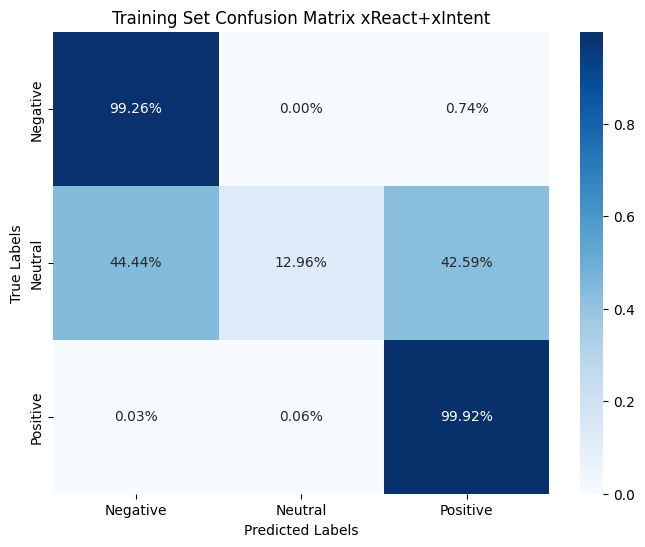

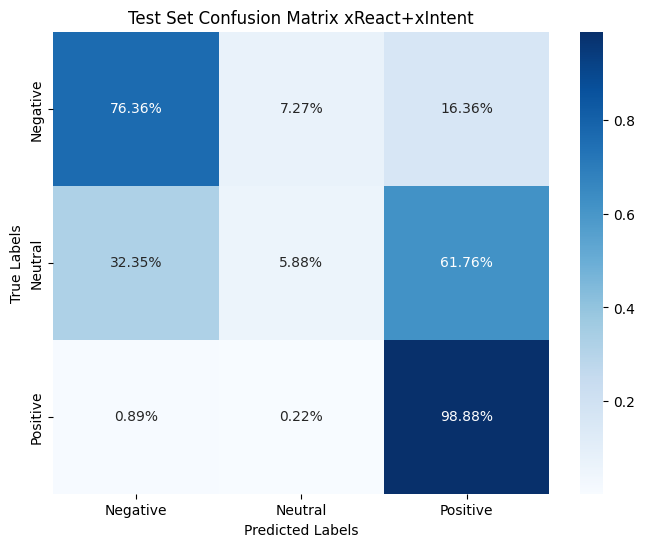

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)

plot_confusion_matrix(train_confusion_matrix_normalized, 'Training Set Confusion Matrix xReact+xIntent')
plot_confusion_matrix(test_confusion_matrix_normalized, 'Test Set Confusion Matrix xReact+xIntent')

### Training Using Only xReact

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

# Split the data
train_texts, val_texts, train_labels, val_labels = train_test_split(df['Summary2'], df['NumericLabels'], test_size=0.2)

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the data
def tokenize_data(texts):
    return tokenizer(texts.tolist(), padding=True, truncation=True, max_length=512, return_tensors="pt")

train_encodings = tokenize_data(train_texts)
val_encodings = tokenize_data(val_texts)

# Convert to torch Dataset
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)

In [ ]:
# Load the BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Training arguments
training_args__ = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
)

# Update the Trainer to include evaluation metrics
trainer__ = Trainer(
    model=model,
    args=training_args__,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer__.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.368000
1000,0.219100


Checkpoint destination directory ./results/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-1000 already exists and is non-empty.Saving will proceed but saved results may be invalid.


TrainOutput(global_step=1476, training_loss=0.2387214624461766, metrics={'train_runtime': 370.049, 'train_samples_per_second': 31.869, 'train_steps_per_second': 3.989, 'total_flos': 3102896535266304.0, 'train_loss': 0.2387214624461766, 'epoch': 3.0})

In [ ]:
# Evaluate on the training set
train_results = trainer__.evaluate(train_dataset)
print(f"Training Set - Accuracy: {train_results['eval_accuracy']}, F1-Score: {train_results['eval_f1']}")  # Corrected keys

# Evaluate on the test set
test_results = trainer__.evaluate(val_dataset)
print(f"Test Set - Accuracy: {test_results['eval_accuracy']}, F1-Score: {test_results['eval_f1']}")  # Corrected keys

Training Set - Accuracy: 0.9758331213431697, F1-Score: 0.9700624996265163
Test Set - Accuracy: 0.9440488301119023, F1-Score: 0.9378288722037361


In [ ]:
train_predictions = trainer__.predict(train_dataset)
test_predictions = trainer__.predict(val_dataset)

train_preds = train_predictions.predictions.argmax(-1)
test_preds = test_predictions.predictions.argmax(-1)

In [ ]:
train_confusion_matrix_normalized = confusion_matrix(train_dataset.labels, train_preds, normalize='true')
test_confusion_matrix_normalized = confusion_matrix(val_dataset.labels, test_preds, normalize='true')

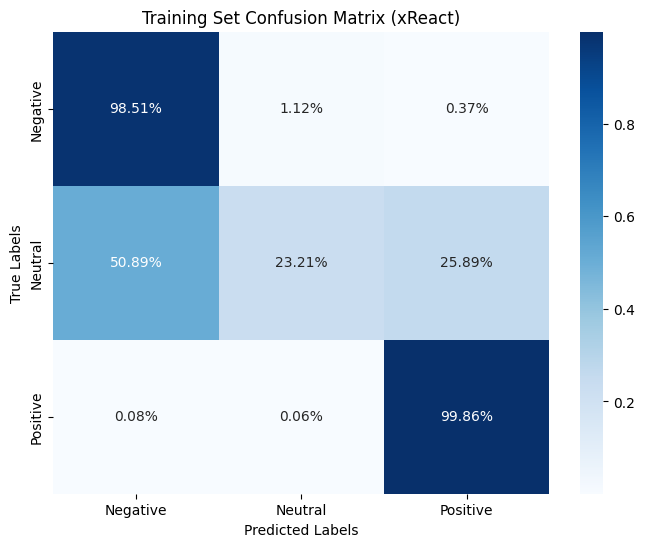

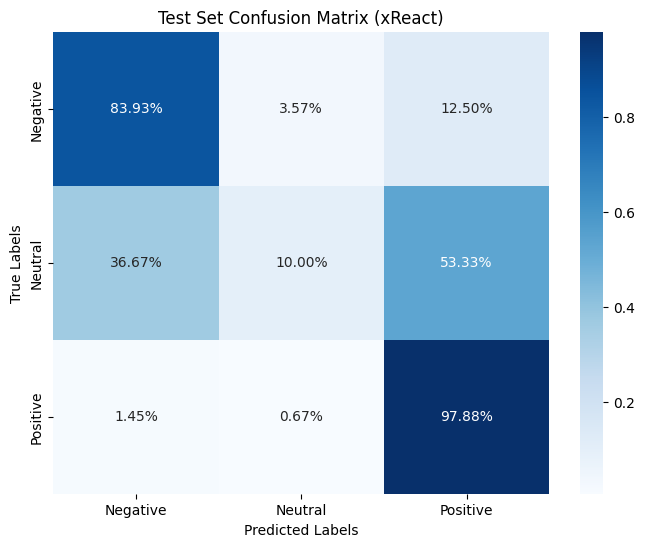

In [ ]:
plot_confusion_matrix(train_confusion_matrix_normalized, 'Training Set Confusion Matrix (xReact)')
plot_confusion_matrix(test_confusion_matrix_normalized, 'Test Set Confusion Matrix (xReact)')

### Training Using Only xIntent

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

# Split the data
train_texts, val_texts, train_labels, val_labels = train_test_split(df['Summary3'], df['NumericLabels'], test_size=0.2)

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the data
def tokenize_data(texts):
    return tokenizer(texts.tolist(), padding=True, truncation=True, max_length=512, return_tensors="pt")

train_encodings = tokenize_data(train_texts)
val_encodings = tokenize_data(val_texts)

# Convert to torch Dataset
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)

In [ ]:
# Load the BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Training arguments
training_args__ = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
)

# Update the Trainer to include evaluation metrics
trainer__ = Trainer(
    model=model,
    args=training_args__,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer__.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.360400
1000,0.210600


Checkpoint destination directory ./results/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-1000 already exists and is non-empty.Saving will proceed but saved results may be invalid.


TrainOutput(global_step=1476, training_loss=0.23119625618787315, metrics={'train_runtime': 376.459, 'train_samples_per_second': 31.326, 'train_steps_per_second': 3.921, 'total_flos': 3102896535266304.0, 'train_loss': 0.23119625618787315, 'epoch': 3.0})

In [ ]:
# Evaluate on the training set
train_results = trainer__.evaluate(train_dataset)
print(f"Training Set - Accuracy: {train_results['eval_accuracy']}, F1-Score: {train_results['eval_f1']}")  # Corrected keys

# Evaluate on the test set
test_results = trainer__.evaluate(val_dataset)
print(f"Test Set - Accuracy: {test_results['eval_accuracy']}, F1-Score: {test_results['eval_f1']}")  # Corrected keys

Training Set - Accuracy: 0.9760875095395574, F1-Score: 0.9694704874305528
Test Set - Accuracy: 0.9348931841302136, F1-Score: 0.9304836750794551


In [ ]:
train_predictions = trainer__.predict(train_dataset)
test_predictions = trainer__.predict(val_dataset)

train_preds = train_predictions.predictions.argmax(-1)
test_preds = test_predictions.predictions.argmax(-1)

In [ ]:
train_confusion_matrix_normalized = confusion_matrix(train_dataset.labels, train_preds, normalize='true')
test_confusion_matrix_normalized = confusion_matrix(val_dataset.labels, test_preds, normalize='true')

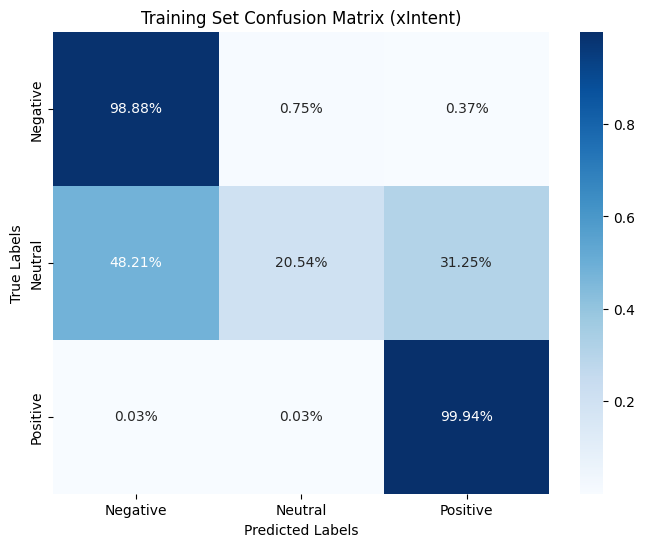

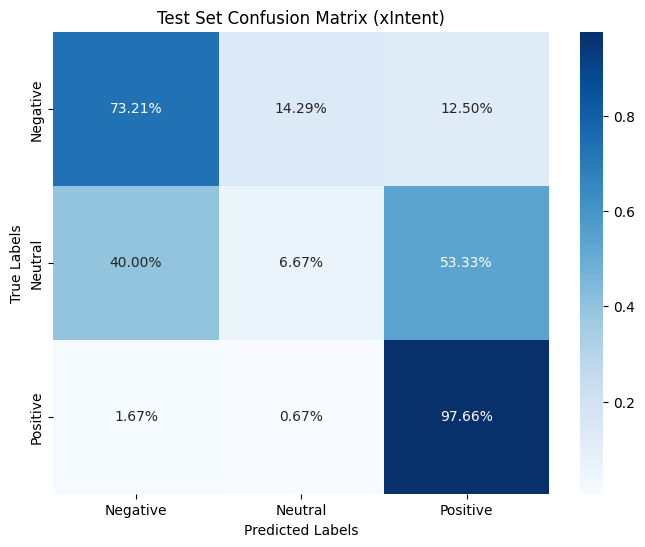

In [ ]:
plot_confusion_matrix(train_confusion_matrix_normalized, 'Training Set Confusion Matrix (xIntent)')
plot_confusion_matrix(test_confusion_matrix_normalized, 'Test Set Confusion Matrix (xIntent)')

### Train Without Common Sense

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

# Split the data
train_texts, val_texts, train_labels, val_labels = train_test_split(df['reviewText'], df['NumericLabels'], test_size=0.2)

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the data
def tokenize_data(texts):
    return tokenizer(texts.tolist(), padding=True, truncation=True, max_length=512, return_tensors="pt")

train_encodings = tokenize_data(train_texts)
val_encodings = tokenize_data(val_texts)

# Convert to torch Dataset
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

# Load the BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Training arguments
training_args_ = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
)

from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')  # Use 'weighted' for imbalanced classes
    return {
        'accuracy': acc,  # Changed from 'eval_accuracy' to 'accuracy'
        'f1': f1,         # Changed from 'eval_f1' to 'f1'
    }

# Update the Trainer to include evaluation metrics
trainer_ = Trainer(
    model=model,
    args=training_args_,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer_.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.372800
1000,0.206700


Checkpoint destination directory ./results/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-1000 already exists and is non-empty.Saving will proceed but saved results may be invalid.


TrainOutput(global_step=1476, training_loss=0.2335606810200182, metrics={'train_runtime': 386.3418, 'train_samples_per_second': 30.525, 'train_steps_per_second': 3.82, 'total_flos': 3102896535266304.0, 'train_loss': 0.2335606810200182, 'epoch': 3.0})

In [ ]:
# Evaluate on the training set
train_results = trainer_.evaluate(train_dataset)
print(f"Training Set - Accuracy: {train_results['eval_accuracy']}, F1-Score: {train_results['eval_f1']}")  # Corrected keys

# Evaluate on the test set
test_results = trainer_.evaluate(val_dataset)
print(f"Test Set - Accuracy: {test_results['eval_accuracy']}, F1-Score: {test_results['eval_f1']}")  # Corrected keys

Training Set - Accuracy: 0.979648944288985, F1-Score: 0.9754579575180597
Test Set - Accuracy: 0.9379450661241099, F1-Score: 0.9333584495030454


In [ ]:
train_predictions_ = trainer_.predict(train_dataset)
test_predictions_ = trainer_.predict(val_dataset)

train_preds_ = train_predictions_.predictions.argmax(-1)
test_preds_ = test_predictions_.predictions.argmax(-1)

In [ ]:
train_confusion_matrix_normalized_ = confusion_matrix(train_dataset.labels, train_preds_, normalize='true')
test_confusion_matrix_normalized_ = confusion_matrix(val_dataset.labels, test_preds_, normalize='true')

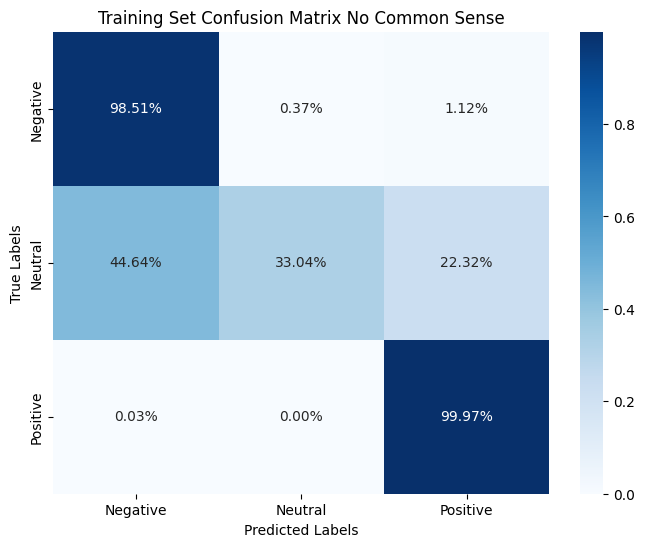

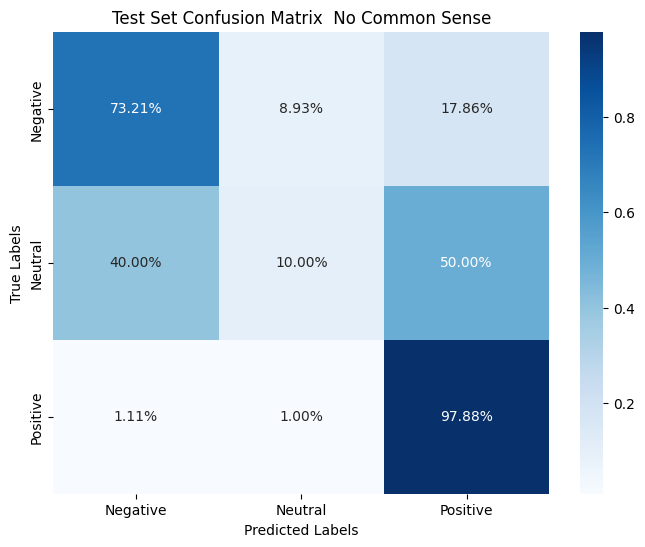

In [ ]:
plot_confusion_matrix(train_confusion_matrix_normalized_, 'Training Set Confusion Matrix No Common Sense')
plot_confusion_matrix(test_confusion_matrix_normalized_, 'Test Set Confusion Matrix  No Common Sense')